<a href="https://colab.research.google.com/github/geoffwoollard/prob_prog/blob/main/projects/pyro_gaussian_unknown_mean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip3 install pyro-ppl 

     |████████████████████████████████| 678 kB 29.7 MB/s 


In [ ]:
import pyro
import torch
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pandas as pd
from torch import tensor

def doplt(arr_2d): return plt.imshow(arr_2d, cmap='gray')
pyro.set_rng_seed(101)


# Tutorial
* http://pyro.ai/examples/intro_part_ii.html

In [ ]:
def scale(guess): # the forward model. takes the same inpute as the guide
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))
    
conditioned_scale = pyro.condition(scale, data={"measurement": torch.tensor(9.5)}) # the observe statements


In [ ]:

def scale_parametrized_guide(guess): # the proposal distribution
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b))) # weight has same form as in scale

In [ ]:
guess = 8.5 # important matches conditioned_scale

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale, # takes in guess, returns sample of weight
                     guide=scale_parametrized_guide, # takes in guess, returns sample of weight
                     optim=pyro.optim.Adam({"lr": 0.003}), # the optimizer
                     loss=pyro.infer.Trace_ELBO()) # the objective to optimize

a =  9.140591621398926
b =  0.592543363571167


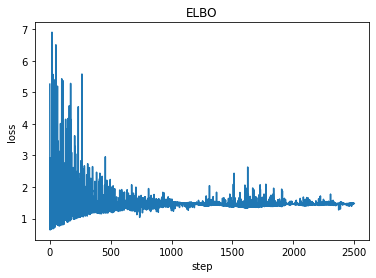

In [ ]:
losses, a, b = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

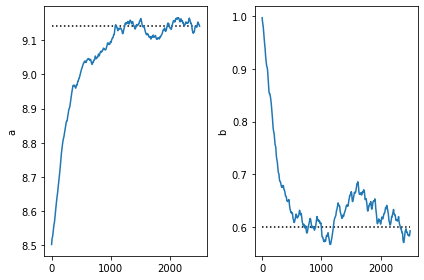

In [ ]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

# extend example
`mu` <-> `weight`
`lik` <-> `measurement`

In [ ]:
import pyro
import torch
import matplotlib.pyplot as plt

pyro.set_rng_seed(101)


In [ ]:
def scale(guess): # the forward model. takes the same inpute as the guide
    mu = pyro.sample("mu", dist.Normal(guess, 1.0))
    return pyro.sample("lik", dist.Normal(mu, 0.75))
    
conditioned_scale = pyro.condition(scale, data={"lik": torch.tensor(9.5)}) # the observe statements


In [ ]:
import pyro.distributions as dist

def scale_parametrized_guide(guess): # the proposal distribution
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("mu", dist.Normal(a, torch.abs(b))) # weight has same form as in scale

In [ ]:
guess = 8.5 # important matches conditioned_scale

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale, # takes in guess, returns sample of weight
                     guide=scale_parametrized_guide, # takes in guess, returns sample of weight
                     optim=pyro.optim.Adam({"lr": 0.003}), # the optimizer
                     loss=pyro.infer.Trace_ELBO()) # the objective to optimize

a =  9.113338470458984
b =  0.6174644231796265


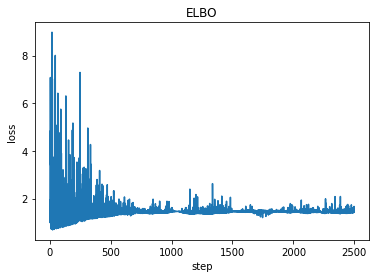

In [ ]:
losses, a, b = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

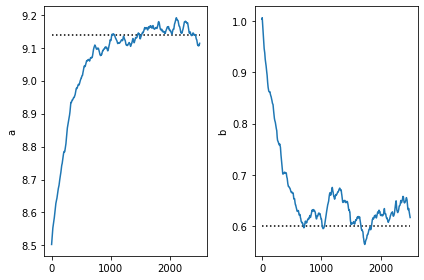

In [ ]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

# Gaussian unknown mean problem (with two observes)

For now I only know how to incorporate one observe, so hte observe lik 9 line has been removed from the original problem.

* https://www.cs.ubc.ca/~fwood/CS532W-539W/homework/2.html
* https://www.cs.ubc.ca/~fwood/CS532W-539W/homework/4.html
```
(let [mu (sample (normal 1 (sqrt 5)))
           sigma (sqrt 2)
           lik (normal mu sigma)]
       (observe lik 8)
       (observe lik 9)
       mu)
```

How do we do this in pyro?

In [ ]:
def forward_model(): # the forward model, does 
    mu = pyro.sample("mu", dist.Normal(1., 5**.5)) # fix guess 1?
    pyro.sample("lik1", dist.Normal(mu, 2**.5), obs=torch.tensor(8.))
    pyro.sample("lik2", dist.Normal(mu, 2**.5), obs=torch.tensor(9.)) # we seem to have to come up with different names. maybe there's a way to to a loop and have lik iid draws

In [ ]:
def parametrized_guide(): # the proposal distribution
    a = pyro.param("a", torch.tensor(1.)) # pyro.param registers as learnable
    b = pyro.param("b", torch.tensor(2**.5), constraint=torch.distributions.constraints.positive)
    return pyro.sample("mu", dist.Normal(a, b)) # naming this mu is important and it links it with the mu in the forward model

In [ ]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=forward_model, # takes in guess, returns sample of weight
                     guide=parametrized_guide, # takes in guess, returns sample of weight
                     optim=pyro.optim.Adam({"lr": 0.003}), # the optimizer
                     loss=pyro.infer.Trace_ELBO()) # the objective to optimize

a =  7.276741027832031
b =  0.8479210138320923


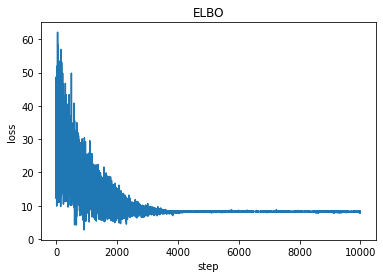

In [ ]:
losses, a, b = [], [], []
num_steps = 2500*4
for t in range(num_steps):
    losses.append(svi.step())
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

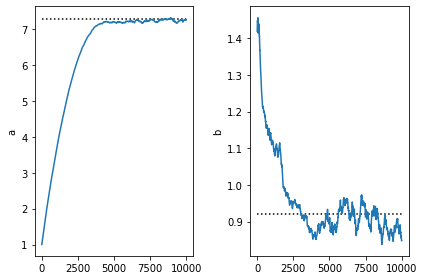

In [ ]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[7.3,7.3], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.92,0.92], 'k:')
plt.plot(b)
plt.tight_layout()

## plates

In [ ]:
def forward_model(): # the forward model, does 
    """converges to hw problem answers
    """
    mu = pyro.sample("mu", dist.Normal(1., 5**.5)) # fix guess 1?
    data = torch.tensor([8.,9.])
    for i in pyro.plate("lik", size=2): 
      # with plate as in https://youtu.be/aLFJ5ERxt2c?t=561 did not work, because lik used twice
      pyro.sample("lik_%d"%i, dist.Normal(mu, 2**.5), obs=data[i])

def forward_model(): # the forward model, does 
    """converges to hw problem answers
    """
    mu = pyro.sample("mu", dist.Normal(1., 5**.5)) # fix guess 1?
    data = torch.tensor([8.,9.])
    with pyro.plate("data", size=2,subsample_size=2) as ids: 
      # pyro.plate(..., size) defines the number of observes 
      # data is the name of the place, vs lik and the other rvs in it
      #as in https://youtu.be/aLFJ5ERxt2c?t=561
      # ids is subsample_size long
      pyro.sample("lik", dist.Normal(mu, 2**.5), obs=data[ids])

def forward_model(): # the forward model, does 
  """ converges to hw problem answers
  """
  mu = pyro.sample("mu", dist.Normal(1., 5**.5)) # fix guess 1?
  num_batches = 10
  size_batch = 1
  data_8 = torch.tensor(8.).repeat(num_batches)
  data_9 = torch.tensor(9.).repeat(num_batches)
  with pyro.plate("data", size=1,subsample_size=size_batch) as ids: # data is the name of the place, vs lik and the other rvs in it
    #as in https://youtu.be/aLFJ5ERxt2c?t=561
    # ids is subsample_size long
    pyro.sample("lik8", dist.Normal(mu, 2**.5), obs=data_8[ids])
    pyro.sample("lik9", dist.Normal(mu, 2**.5), obs=data_9[ids])

In [ ]:
def parametrized_guide(): # the proposal distribution
    """
    every sample statement in model without obs must have a corresponsing statement in the guide (here mu)
    no obs in the guide

    https://medium.com/paper-club/understanding-pyros-model-and-guide-a-love-story-7f3aa0603886
    https://cscherrer.github.io/post/pyro/

    """
    a = pyro.param("a", torch.tensor(1.)) # pyro.param registers as learnable
    b = pyro.param("b", torch.tensor(2**.5), constraint=torch.distributions.constraints.positive)
    return pyro.sample("mu", dist.Normal(a, b)) # naming this mu is important and it links it with the mu in the forward model

In [ ]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=forward_model, # takes in guess, returns sample of weight
                     guide=parametrized_guide, # takes in guess, returns sample of weight
                     optim=pyro.optim.Adam({"lr": 0.003}), # the optimizer
                     loss=pyro.infer.Trace_ELBO()) # the objective to optimize

a =  7.2446818351745605
b =  0.8962703347206116


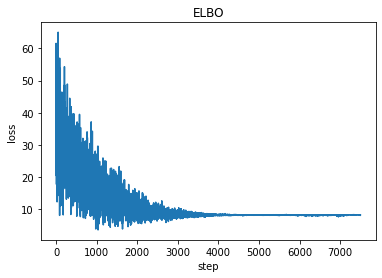

In [ ]:
losses, a, b = [], [], []
num_steps = 2500*3
for t in range(num_steps):
    losses.append(svi.step())
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

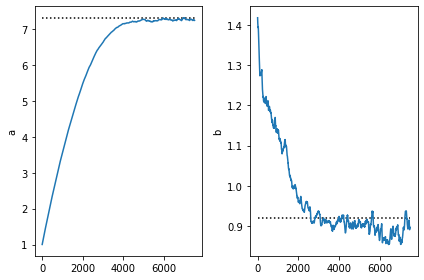

In [ ]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[7.3,7.3], 'k:')
plt.plot(a)
plt.ylabel('a')
plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.92,0.92], 'k:')
plt.plot(b)
plt.tight_layout()

# observes as iid data elements
* observes can be fed in to `.step` as in http://pyro.ai/examples/vae.html
* data batches https://alexrachnog.medium.com/financial-forecasting-with-probabilistic-programming-and-pyro-db68ab1a1dba

In [ ]:
def forward_model(observed_data): # the forward model, does 
    mu = pyro.sample("mu", dist.Normal(1., 5**.5)) # fix guess 1?
    with pyro.plate("data", 2):
      pyro.sample("lik", dist.Normal(mu, 2**.5), obs=observed_data)
      #pyro.sample("lik2", dist.Normal(mu, 2**.5), obs=torch.tensor(9.)) # we seem to have to come up with different names. maybe there's a way to to a loop and have lik iid draws

In [ ]:
def parametrized_guide(observed_data): # the proposal distribution
    observed_data = None
    a = pyro.param("a", torch.tensor(1.)) # pyro.param registers as learnable
    b = pyro.param("b", torch.tensor(2**.5), constraint=torch.distributions.constraints.positive)
    return pyro.sample("mu", dist.Normal(a, b)) # naming this mu is important and it links it with the mu in the forward model

In [ ]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=forward_model, # takes in guess, returns sample of weight
                     guide=parametrized_guide, # takes in guess, returns sample of weight
                     optim=pyro.optim.Adam({"lr": 0.003}), # the optimizer
                     loss=pyro.infer.Trace_ELBO()) # the objective to optimize

a =  7.249650001525879
b =  0.9262166023254395


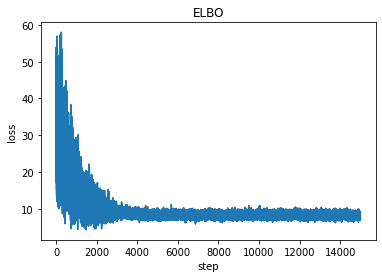

In [ ]:
losses, a, b = [], [], []
num_steps = 2500*3
for t in range(num_steps):
  for observed_data in [torch.tensor(8.),torch.tensor(9.)]: # this is NOT how to use plates. this is definint a prob prog with one observe, with its value given by what is fed in (50% of time 8, 50% 9)
    losses.append(svi.step(observed_data))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

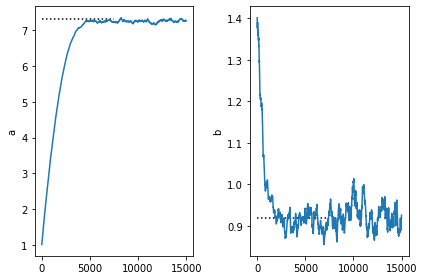

In [ ]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[7.3,7.3], 'k:')
plt.plot(a)
plt.ylabel('a')
plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.92,0.92], 'k:')
plt.plot(b)
plt.tight_layout()

# importance

In [ ]:
from pyro.infer.importance import vectorized_importance_weights


In [ ]:
%%time

pyro.clear_param_store()
log_weights, model_trace, guide_trace = \
    vectorized_importance_weights(forward_model, parametrized_guide,
                                  num_samples=10000000,
                                  max_plate_nesting=4,
                                  normalized=False)

CPU times: user 744 ms, sys: 475 ms, total: 1.22 s
Wall time: 1.22 s


In [ ]:
pyro.infer.importance(forward_model, parametrized_guide)

TypeError: ignored

# 1D gaussian signal with shift
* gaussian pixelated noise $\sigma_{noise}$
* prior of shift is gaussian with fixed and known param $\sigma_{shift}$

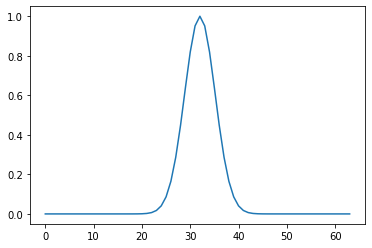

In [ ]:
num_pix = 64
domain = torch.arange(-num_pix//2, num_pix//2)
sigma_signal = 10
clean_signal = torch.exp(-domain**2/(2*sigma_signal))
pd.Series(clean_signal).plot()

In [ ]:
# synthetic data. normally, these would come from actual measurements and we would not know shift. h
# ere we have access to the ground truth
sigma_noise = 0.1
num_particles = 1000
data = torch.empty((num_particles,num_pix))
for i in range(num_particles):
  shift = dist.Normal(0,2).sample()
  clean_signal = torch.exp(-(domain-shift)**2/(2*sigma_signal))
  data[i] = dist.Normal(clean_signal,sigma_noise).sample()

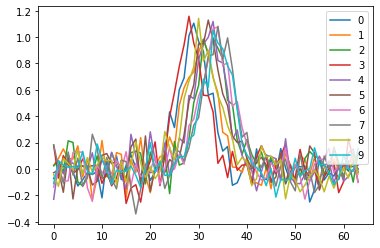

In [ ]:
pd.DataFrame(data[:10].numpy().T).plot()

In [ ]:
# def model(data):
#   batch_size=1
#   shift = pyro.sample('shift',dist.Normal(0,2))
#   clean_signal = torch.exp(-(domain-shift)**2/(2*sigma_signal))
#   for i in pyro.plate("data", size=len(data), subsample_size=batch_size):
#     pyro.sample("particle_1d_%d"%i, dist.Normal(clean_signal, sigma_noise).to_event(1), obs=data[i])

def model(data):
  batch_size=10
  shift = pyro.sample('shift',dist.Normal(0,2)) # TODO: what if we don't know 0,2 here, we just use best guess
  clean_signal = torch.exp(-(domain-shift)**2/(2*sigma_signal))
  with pyro.plate("data", size=num_particles, subsample_size=batch_size) as ids:
    pyro.sample("particle_1d", dist.Normal(clean_signal, sigma_noise).to_event(1), obs=data[ids])

In [ ]:
def guide(data): # the proposal distribution
  """
  learn the parameters of our modelled encoding of the signal (a 1D atom)
  hard coded fixed noise of 0.1
  """
  shift_mean = pyro.param("shift_mean", torch.tensor(0.))
  shift_std = pyro.param("shift_std", torch.tensor(2.), constraint=torch.distributions.constraints.positive)
  shift = pyro.sample('shift',dist.Normal(shift_mean,shift_std))

In [ ]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model, # takes in guess, returns sample of weight
                     guide=guide, # takes in guess, returns sample of weight
                     optim=pyro.optim.Adam({"lr": 0.003}), # the optimizer
                     loss=pyro.infer.Trace_ELBO())

shift_mean =  -0.03807112202048302
shift_std =  1.6731318235397339


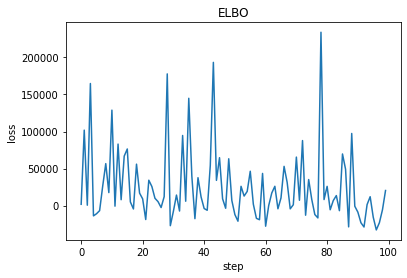

In [ ]:
losses, shift_mean, shift_std = [], [], []
num_steps = 100
for t in range(num_steps):
    losses.append(svi.step(data))
    shift_mean.append(pyro.param("shift_mean").item())
    shift_std.append(pyro.param("shift_std").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('shift_mean = ',pyro.param("shift_mean").item())
print('shift_std = ',pyro.param("shift_std").item())

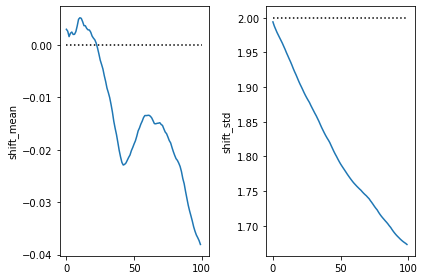

In [ ]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[0,0], 'k:')
plt.plot(shift_mean)
plt.ylabel('shift_mean')
plt.subplot(1,2,2)
plt.ylabel('shift_std')
plt.plot([0,num_steps],[2,2], 'k:')
plt.plot(shift_std)
plt.tight_layout()

# analytic solution

First let's work through the prob prog symbolically. We can get a analytic pdf for p(lik), which is a Gaussian centred at a Gaussian
$$
\mu \sim N[1,5] = 1 + N[0,5] \\
lik \sim N[\mu,2] = \mu + N[0,2] \\
= (1 + N[0,5]) + N[0,2]  = N[1,1^1+5^2=29]
$$

Thus `lik` is normal with mean 1 and var 29.

Now let's find the posterior of $\mu$

$$
p(\mu|lik=8,9) 
\\
= \frac{p(lik=8,9|\mu)p(\mu)}{p(lik=8,9)}
\\
= N[lik=8|\mu,\sigma^2]
N[lik=9|\mu,\sigma^2]
N[\mu|1,5]
\\
=
\frac{
  C_{\sigma^2}\exp\frac{-(8-\mu)^2}{2\sigma^2}
  C_{\sigma^2}\exp\frac{-(9-\mu)^2}{2\sigma^2}
  C_{5}\exp\frac{-(\mu-1)^2}{2\cdot5}
}
{
  C_{29}\exp\frac{-(8-1)^2}{2\cdot29}
  C_{29}\exp\frac{-(9-1)^2}{2\cdot29}
}
$$

The link shows that https://en.wikipedia.org/wiki/Normal_distribution#With_known_variance

with $n=2$,$\tau = 1/\sigma^2, \mu_0=1,\tau_0=1/\sqrt{5},x_i=\{8,9\}$

Thus this is our model, and we can use amortized inference to train a guide that contumes paris of data (like 8,9, but any pair) and gives back the params of the distribution that characterize the posterior of `mu`. 

We can use a neural net in the guide, which sees data, and predicts the params of a distribution: here `loc` and `scale` of a normal distribution. It essentially learns to invert the function. I.e. it is a quick neural net approx to an inverse function.

We train it by simulating the data generation process. Here that means now "what `mu` was (sampled)", but the parameters of the distribution that mu was sampled from, given the data. In our case, it has the opportunity to be exact, because the posterior in this special case can be analytically shown to be a normal distribution.

In [ ]:
data = tensor([8.,9.])
sigma0 = torch.sqrt(tensor(5.))
sigma = torch.sqrt(tensor(2.))
u0=tensor(1.)
def analytic_inversion(pair,sigma0=sigma0,sigma=sigma):
  n=2
  #u0=1
  #sigma0 = torch.sqrt(tensor(5.))
  t0=1/sigma0**2
  #sigma = torch.sqrt(tensor(2.))
  t=1/sigma**2
  x_bar=pair.mean()
  t0_ = t0 + n*t
  u0_ = (n*t*x_bar + t0*u0) / (n*t + t0)
  scale_ = 1/torch.sqrt(t0_)
  return u0_.item(), scale_.item()

analytic_inversion(data)
# posterior_mu_analytic = dist.Normal(u0_,scale_)
# posterior_mu_analytic

(7.249999523162842, 0.9128708839416504)

## no amortizatoin, just single data pair (8,9)

In [ ]:
def model(data): # the forward model, does 
    mu = pyro.sample("mu", dist.Normal(1., sigma0))
    with pyro.plate("data", size=2,subsample_size=2) as ids: 
      pyro.sample("lik", dist.Normal(mu, 2**.5), obs=data[ids])

def guide(data):
  loc = pyro.param('loc',data.mean())
  scale = pyro.param('scale',tensor(1.), constraint=torch.distributions.constraints.positive)
  pyro.sample('mu',dist.Normal(loc,scale))

pyro.clear_param_store()
svi = pyro.infer.SVI(model=model, # takes in guess, returns sample of weight
                     guide=guide, # takes in guess, returns sample of weight
                     optim=pyro.optim.Adam({"lr": 0.003}), # the optimizer
                     loss=pyro.infer.Trace_ELBO()) # the objective to optimize

loc =  7.286187648773193
scale =  0.8947651386260986


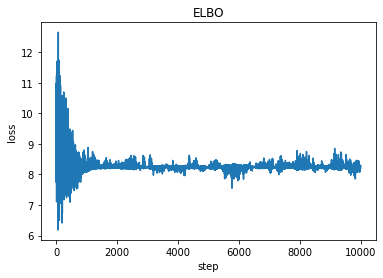

In [ ]:
losses, loc, scale = [], [], []
num_steps = 10000
for t in range(num_steps):
    losses.append(svi.step(data))
    loc.append(pyro.param("loc").item())
    scale.append(pyro.param("scale").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('loc = ',pyro.param("loc").item())
print('scale = ', pyro.param("scale").item())

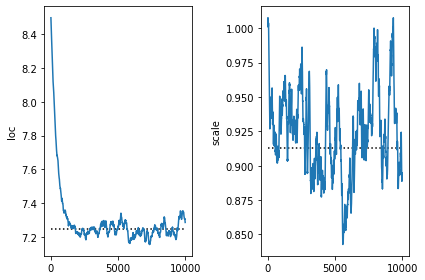

In [ ]:
plt.subplot(1,2,1)
analytic_loc, analytic_scale = analytic_inversion(data)
plt.plot([0,num_steps],[analytic_loc,analytic_loc], 'k:')
plt.plot(loc)
plt.ylabel('loc')

plt.subplot(1,2,2)
plt.ylabel('scale')
plt.plot([0,num_steps],[analytic_scale,analytic_scale], 'k:')
plt.plot(scale)
plt.tight_layout()

## amortization for any pairs
Here we train an mlp to learn to maps R2 to R2. The input will be an arbitrary pair of observations (oridinal problem is 8,9) and the output will be the params for the posterior of mu (defined as so in the guide).
* we simplify this a bit further to fix the first item of the observation pair at 8, the second item in (8,10), so 9 will be very well covered "in distribution". 

In [ ]:
from torch import nn

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    hidden_layer_1_size = 4
    hidden_layer_2_size = 4
    input_size = 2
    output_size = 2
    self.layers = nn.Sequential(
      nn.Linear(input_size,hidden_layer_1_size),
      nn.Linear(hidden_layer_1_size, hidden_layer_2_size),
      nn.ReLU(),
      nn.Linear(hidden_layer_2_size, output_size)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

mlp = MLP()



In [ ]:
def model(data): # the forward model, does 
    mu = pyro.sample("mu", dist.Normal(u0, sigma0))
    # with pyro.plate("data", size=full_size,subsample_size=2) as ids: 
    #   print('ids',ids)
    pyro.sample("lik1", dist.Normal(mu, sigma), obs=data[0])
    pyro.sample("lik2", dist.Normal(mu, sigma), obs=data[1])

def guide(data):
  pyro.module("mlp", mlp)
  # with pyro.plate("data", full_size, subsample_size=1):
  loc, log_scale = mlp(data)
  scale = torch.exp(log_scale)
  return pyro.sample('mu',dist.Normal(loc,scale))

pyro.clear_param_store()
svi = pyro.infer.SVI(model=model, # takes in guess, returns sample of weight
                     guide=guide, # takes in guess, returns sample of weight
                     optim=pyro.optim.Adam({"lr": 0.003}), # the optimizer
                     loss=pyro.infer.Trace_ELBO()) # the objective to optimize

In [ ]:
losses, loc, scale = [], [], []
num_diff_datapts = 100
data = torch.zeros((num_diff_datapts,2))
data[:,0] = 8.#torch.arange(100) + 1.
data[:,1] = 2*torch.rand(num_diff_datapts).sort().values + 8 #torch.arange(100) + 1.
random_idx = torch.randperm(num_diff_datapts) + 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


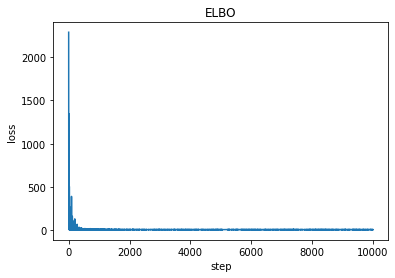

In [ ]:
num_steps = 10000
for t in range(num_steps):
  if (t % (num_steps//10)) == 0: print(t)
  if (t % 100) == 0: random_idx = torch.randperm(100)
  pair = data[random_idx[t%100]]
  losses.append(svi.step(pair))

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");

In [ ]:
amortized_loc, amortized_log_scale = mlp(tensor([8.,9.]))
amortized_loc, torch.exp(amortized_log_scale)

(tensor(7.3127, grad_fn=<UnbindBackward0>),
 tensor(0.8977, grad_fn=<ExpBackward0>))

In [ ]:
analytic_loc_list = []
analytic_scale_list = []
amortized_loc_list = []
amortized_scale_list = []
for pair in data:
  analytic_loc, analytic_scale = analytic_inversion(pair)
  analytic_loc_list.append(analytic_loc)
  analytic_scale_list.append(analytic_scale)
  amortized_loc, amortized_log_scale = mlp(pair)
  amortized_loc_list.append(amortized_loc.item())
  amortized_scale_list.append(torch.exp(amortized_log_scale).item())

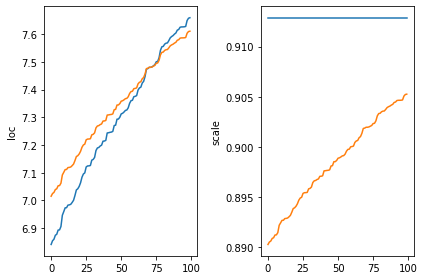

In [ ]:
plt.subplot(1,2,1)
plt.plot(analytic_loc_list)
plt.plot(amortized_loc_list)
plt.ylabel('loc')

plt.subplot(1,2,2)
plt.plot(analytic_scale_list)
plt.plot(amortized_scale_list)
plt.ylabel('scale')
plt.tight_layout()

## amortization with plates

In [ ]:
mlp = MLP()

In [ ]:
def model(data): # the forward model, does 
    mu = pyro.sample("mu", dist.Normal(u0, sigma0))
    full_size = len(data)
    with pyro.plate("data", size=full_size,subsample=data): 
    #   print('ids',ids)
    pyro.sample("lik1", dist.Normal(mu, sigma), obs=data[0])
    pyro.sample("lik2", dist.Normal(mu, sigma), obs=data[1])

def guide(data):
  pyro.module("mlp", mlp)
  # with pyro.plate("data", full_size, subsample_size=1):
  loc, log_scale = mlp(data)
  scale = torch.exp(log_scale)
  return pyro.sample('mu',dist.Normal(loc,scale))

pyro.clear_param_store()
svi = pyro.infer.SVI(model=model, # takes in guess, returns sample of weight
                     guide=guide, # takes in guess, returns sample of weight
                     optim=pyro.optim.Adam({"lr": 0.003}), # the optimizer
                     loss=pyro.infer.Trace_ELBO()) # the objective to optimize